<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - TheiaVision: Object Detection Technology for PMD Safety Alerts

> Authors: Ng Wei
---

**Problem Statement:**  
How can we enhance the safety of Personal Mobility Devices (PMDs) in urban environments by using object detection to improve PMD users' ability to perceive and respond to their surroundings?

**Target Audience:**
Management Team of PMD Maker

**Summary:**
This project aims to develop a object detection system to identifies obstacles such as pedestrians, vehicles, and traffic signs. By leveraging CNN algorithms YOLO model, this system would help Darren, a project manager, to lead the development of an alert system with object detection technology

There are a total of three notebooks for this project:  
 1. `01_EDA.ipynb`   
 2. `02_Modelling_Pytorch_SimpleCNN_SGTrafficSign.ipynb`   
 3. `03_Modelling_YOLOv8_labeled_SGTrafficSign.ipynb`
 4. `04_Merge_MultiDataset.ipynb`
 5. `05_Modelling_YOLOv8_combined_data.ipynb`
 6. `06_YOLOv8_Hyperparameter_Tuning.ipynb`

---
**This Notebook**
- We will look at the performace of Pytorch simple CNN with out Singapore Traffic Sign dataset.

# 2.1 Importing Libraries
This section of the code is responsible for importing the necessary libraries that will be used in the program.

In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose

# 2.2 Assigning file path

This section of the code is responsible to specify the file path of Singapore Traffic Sign image data, each train and test data.

In [2]:
base_dir = ''
base_img_folder = '../data/singapore_traffic_sign'
train_img_folder = 'TRAIN'
test_img_folder = 'TEST'

dataset_dir = os.path.join(base_dir, base_img_folder)
train_dir = os.path.join(dataset_dir, train_img_folder)
test_dir = os.path.join(dataset_dir, test_img_folder)

# 2.3 Pytorch Simple CNN Modelling
Below section is to setup simple CNN using Pytorch framework.
Unlike Tensorflow, Pytorch need to manual setup without keras library.

## 2.3.1 Model Setup

This Python code is using the PyTorch library to prepare image data for training, validation, and testing of a Convolutional Neural Network (CNN).

The first two blocks of code define transformations that will be applied to the images before they are used in the model. These transformations are used to standardize the images and sometimes to augment the data to improve model performance.

The transform_train block is for the training data. It resizes all images to 50x50 pixels, applies a random affine transformation (which can include rotation, translation, and scaling), converts the images to PyTorch tensors, and normalizes the pixel values to be between -1 and 1 (assuming the original pixel values are between 0 and 1).

The transform_test block is for the testing data. It resizes and normalizes the images in the same way as the training data, but does not apply the random affine transformation. This is because we want to test the model on the original images, not augmented versions of them.

The datasets.ImageFolder lines create datasets from images in the specified directories (train_dir and test_dir). The images in these directories are loaded, and the transformations specified earlier are applied.

Finally, the DataLoader lines create data loaders from the datasets. These data loaders are iterable objects that will yield batches of images and their corresponding labels when iterated over. The batch_size parameter specifies how many images to include in each batch. The shuffle parameter determines whether to shuffle the data before creating batches. The num_workers parameter specifies how many subprocesses to use for data loading. The more subprocesses, the faster the data can be loaded, but also the more memory that is used.

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.RandomAffine(degrees=0.1, translate=(0.25, 0.25), scale=(0.75, 1.25)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
validation_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)



The below code defines a simple Convolutional Neural Network (CNN) using PyTorch's nn.Module. This CNN is designed for image classification tasks.

The SimpleCNN class inherits from nn.Module, which is the base class for all neural network modules in PyTorch. This inheritance allows the SimpleCNN class to utilize PyTorch's built-in functionalities for neural networks.

In the __init__ method, the layers of the neural network are defined. The super(SimpleCNN, self).__init__() line is calling the constructor of the parent class (nn.Module), which is necessary for the proper functioning of the network.

The conv1 layer is a 2D convolutional layer with 3 input channels, 32 output channels, a kernel size of 3, and padding of 1. This layer is designed to detect features in the input images.

The relu layer is a Rectified Linear Unit (ReLU) activation function. It introduces non-linearity into the model, allowing it to learn more complex patterns.

The pool layer is a 2D max pooling layer with a kernel size of 2 and stride of 2. This layer reduces the spatial dimensions (height, width) of the input, which helps to control overfitting.

The fc1 and fc2 layers are fully connected (dense) layers. The fc1 layer has 322525 input features and 32 output features. The fc2 layer has 32 input features and 7 output features. The output of fc2 represents the logits for each of the 7 classes that the model is designed to classify.

In the forward method, the forward pass of the network is defined. The input x is passed through each layer in turn, with the output of one layer serving as the input to the next. The view function is used to flatten the output of the pooling layer before it is passed to the fc1 layer. The final output of the forward method is the logits for each class.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define the layers of the model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Adjust the size here appropriately based on your image input size
        self.fc1 = nn.Linear(32 * 25 * 25, 32)  # Calculate the flattened size correctly
        self.fc2 = nn.Linear(32, 7)  # Assuming 7 classes, adjust if different

    def forward(self, x):
        # Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))  # Convolution, ReLU activation, and Pooling
        x = x.view(-1, 32 * 25 * 25)  # Flatten the output for the Dense layer
        x = self.relu(self.fc1(x))  # First fully connected layer
        x = self.fc2(x)  # Output logits directly
        return x



## 2.3.2 Mount Model on CUDA

This Python code is part of a machine learning script using the PyTorch library. It's setting up a simple Convolutional Neural Network (CNN) model for training.

The first line is checking if CUDA is available. CUDA is a parallel computing platform and API model created by NVIDIA, which allows developers to use NVIDIA GPUs for general purpose processing. The torch.device function is used to move tensors to and from GPU as required. If CUDA is available, it will use the GPU for processing, otherwise, it will default to the CPU.

The second line is defining the model. SimpleCNN() is a user-defined class that presumably implements a simple Convolutional Neural Network. The details of this class are not shown in the provided code, but it would typically define the architecture of the neural network, including layers, activation functions, etc.

The third line is moving the model to the chosen device (either GPU or CPU). The to(device) function is used to ensure that all the computations for the model will be done on the specified device.

The fourth line is defining the optimizer. In this case, RMSprop (Root Mean Square Propagation) is used, which is a popular gradient descent optimization algorithm for deep learning networks. The model.parameters() function is used to pass all the trainable parameters of the model to the optimizer. The learning rate is set to 0.001.

The fifth line is defining the loss function. In this case, Cross Entropy Loss is used, which is a common choice for classification problems. This function will compare the model's predictions with the true values and calculate a score that the model will attempt to minimize during training.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()  # Define the model
model.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## 2.3.3 Modelling

This Python code is part of a machine learning script using the PyTorch library. It's defining two functions, train_model and validate_model, and then calling train_model to train a Convolutional Neural Network (CNN) model.

The train_model function is used to train the model. It takes four arguments: the model to be trained, the training data loader, the validation data loader, and the number of epochs to train for. An epoch is one complete pass through the entire training dataset. Inside the function, it first sets the model to training mode with model.train(). Then it loops over the number of epochs. For each epoch, it records the start time, then loops over the training data. For each batch of data, it moves the inputs and labels to the device (GPU or CPU), clears the gradients of all optimized variables, performs a forward pass (computes predicted outputs by passing inputs to the model), calculates the loss, performs a backward pass (computes gradient of the loss with respect to model parameters), and performs an optimization step (updates the model parameters). After each epoch, it prints out the loss and the time taken for that epoch, and calls validate_model to evaluate the model on the validation data.

The validate_model function is used to evaluate the model. It takes two arguments: the model and the data loader. Inside the function, it first sets the model to evaluation mode with model.eval(). Then it initializes counters for the total number of items and the number of correct predictions. It loops over the data, and for each batch of data, it moves the inputs and labels to the device, performs a forward pass, gets the predictions by taking the index of the maximum value of the output tensor along dimension 1 (which gives the class with the highest predicted probability), increments the total count by the batch size, and increments the correct count by the number of correct predictions in the batch (where the predicted class equals the true class). After looping over all the data, it calculates and prints out the validation accuracy.

Finally, the train_model function is called with the model, the training data loader, the validation data loader, and 50 epochs. This will train the model for 50 epochs, printing out the loss and time for each epoch and the validation accuracy after each epoch.

In [6]:
def train_model(model, train_loader, validation_loader, epochs):
    model.train()
    for epoch in range(epochs):
        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end = time.time()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Time: {end - start}s')

        validate_model(model, validation_loader)

def validate_model(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

train_model(model, train_loader, validation_loader, 50)


Epoch 1, Loss: 2.217103958129883, Time: 0.4465951919555664s
Validation Accuracy: 32.31492361927145%
Epoch 2, Loss: 1.657037377357483, Time: 0.41130685806274414s
Validation Accuracy: 30.19976498237368%
Epoch 3, Loss: 1.4768717288970947, Time: 0.4237937927246094s
Validation Accuracy: 42.068155111633374%
Epoch 4, Loss: 1.270642876625061, Time: 0.43118858337402344s
Validation Accuracy: 48.413631022326676%
Epoch 5, Loss: 1.0846707820892334, Time: 0.43531107902526855s
Validation Accuracy: 57.34430082256169%
Epoch 6, Loss: 1.1072057485580444, Time: 0.4144728183746338s
Validation Accuracy: 69.68272620446534%
Epoch 7, Loss: 0.9026185274124146, Time: 0.4285907745361328s
Validation Accuracy: 66.50998824911868%
Epoch 8, Loss: 0.7488252520561218, Time: 0.4291517734527588s
Validation Accuracy: 70.62279670975323%
Epoch 9, Loss: 0.7401230335235596, Time: 0.41219568252563477s
Validation Accuracy: 74.14806110458284%
Epoch 10, Loss: 0.7530925869941711, Time: 0.414872407913208s
Validation Accuracy: 73.325

## 2.3.4 Model Result

Below code show the model accuracy and loss function

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {average_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

# Assuming the model, test_loader and criterion are already defined and initialized
evaluate_model(model, test_loader, criterion)

Test Loss: 0.6306
Test Accuracy: 85.06%


Below code show the model accuracy and loss function

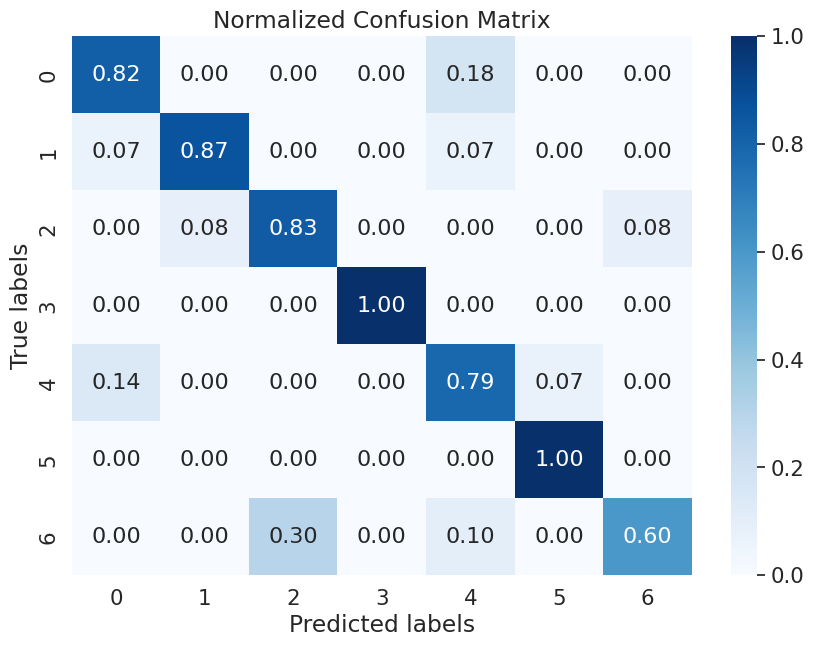

In [8]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions_and_labels(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)  # Ensure images are on the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
    return all_preds, all_labels

# Assuming test_loader is defined and properly set up
predictions, labels = get_predictions_and_labels(model, test_loader)

# Normalizing the confusion matrix by the true (rows) condition
cm = confusion_matrix(labels, predictions, normalize='true')

sns.set(font_scale=1.4)  # for label size
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt=".2f", cmap='Blues')  # font size and format
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()